### Тема “Обучение с учителем”

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

Задание 1. 
Импортируйте библиотеки pandas и numpy.
Загрузите "Boston House Prices dataset" из встроенных наборов данных библиотеки sklearn. Создайте датафреймы X и y из этих данных.
Разбейте эти датафреймы на тренировочные (X_train, y_train) и тестовые (X_test, y_test) с помощью функции train_test_split так, чтобы размер тестовой выборки составлял 30% от всех данных, при этом аргумент random_state должен быть равен 42.
Создайте модель линейной регрессии под названием lr с помощью класса LinearRegression из модуля sklearn.linear_model.
Обучите модель на тренировочных данных (используйте все признаки) и сделайте предсказание на тестовых.
Вычислите R2 полученных предказаний с помощью r2_score из модуля sklearn.metrics.


In [2]:
boston = load_boston()
boston.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])

In [3]:
data = boston.data
target = boston.target
feature_names = boston.feature_names
feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [4]:
for line in boston.DESCR.split('\n'):
    print(line)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [5]:
X = pd.DataFrame(data, columns = feature_names)
y = pd.DataFrame(target, columns = ['price'])
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 1 columns):
price    506 non-null float64
dtypes: float64(1)
memory usage: 4.0 KB


Уменьшение объема памяти, который занимает датасет**

https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [8]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
116,0.13158,0.0,10.01,0.0,0.547,6.176,72.5,2.7301,6.0,432.0,17.8,393.30,12.04
45,0.17142,0.0,6.91,0.0,0.448,5.682,33.8,5.1004,3.0,233.0,17.9,396.90,10.21
16,1.05393,0.0,8.14,0.0,0.538,5.935,29.3,4.4986,4.0,307.0,21.0,386.85,6.58
468,15.57570,0.0,18.10,0.0,0.580,5.926,71.0,2.9084,24.0,666.0,20.2,368.74,18.13


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_test_scaled.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.406801,-0.505125,-1.022256,-0.281546,-0.405218,0.125771,0.553831,-0.527348,-0.514369,-0.667776,-0.744571,0.412412,-0.476058
1,-0.411057,1.266629,-0.681651,3.551814,-0.945403,0.601965,-1.299478,0.146831,-0.630274,-0.920352,-0.300837,0.428541,-1.251858
2,-0.405120,-0.505125,2.396785,-0.281546,0.443643,-0.477130,1.085934,-0.893900,-0.630274,1.827911,0.808498,0.350317,0.795352
3,-0.406818,-0.505125,-0.046624,-0.281546,-1.236931,-0.362955,-2.208034,0.716631,-0.630274,-0.613653,0.409138,0.359533,-0.971669
4,0.195119,-0.505125,1.005500,-0.281546,1.335376,-0.039923,0.832552,-0.658340,1.687825,1.557294,0.852872,0.292484,0.682714


In [10]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

Text(0, 0.5, 'Признаки')

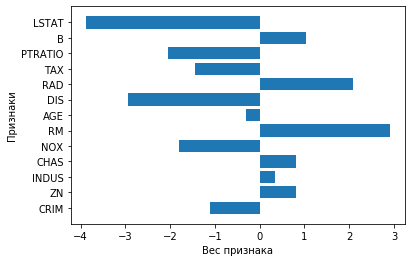

In [11]:
plt.barh(X_train_scaled.columns, lr.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признаки')

In [12]:
R2 = r2_score(y_test, y_pred)
R2

0.7112260057484933

Задание 2. 
Создайте модель под названием model с помощью RandomForestRegressor из модуля sklearn.ensemble.
Сделайте агрумент n_estimators равным 1000,
max_depth должен быть равен 12 и random_state сделайте равным 42.
Обучите модель на тренировочных данных аналогично тому, как вы обучали модель LinearRegression,
но при этом в метод fit вместо датафрейма y_train поставьте y_train.values[:, 0],
чтобы получить из датафрейма одномерный массив Numpy,
так как для класса RandomForestRegressor в данном методе для аргумента y предпочтительно применение массивов вместо датафрейма.
Сделайте предсказание на тестовых данных и посчитайте R2. Сравните с результатом из предыдущего задания.
Напишите в комментариях к коду, какая модель в данном случае работает лучше.


In [13]:
rf = RandomForestRegressor(n_estimators=1000, max_depth=12, random_state=42)
rf.fit(X_train_scaled, y_train.values[:, 0])
y_pred = rf.predict(X_test_scaled)

R2 = r2_score(y_test, y_pred)
R2

0.8748630821769202

Вторая модель с RandomForestRegressor работает лучше первой с LinearRegression: R2 0.87 против 0.71

Задание 3. 
Вызовите документацию для класса RandomForestRegressor,
найдите информацию об атрибуте feature_importances_.
С помощью этого атрибута найдите сумму всех показателей важности,
установите, какие два признака показывают наибольшую важность.


Feature ranking:
1. feature 12 (0.415679)
2. feature 5 (0.402705)
3. feature 7 (0.064033)
4. feature 0 (0.032117)
5. feature 10 (0.018090)
6. feature 4 (0.014368)
7. feature 6 (0.014245)
8. feature 11 (0.012311)
9. feature 9 (0.011692)
10. feature 2 (0.007094)
11. feature 8 (0.004968)
12. feature 1 (0.001550)
13. feature 3 (0.001149)


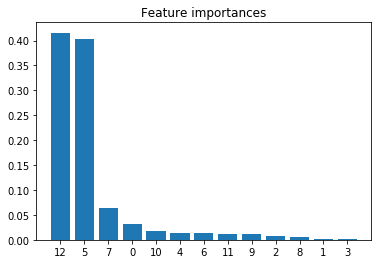

In [14]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [15]:
# Cуммa всех показателей важности:
round(rf.feature_importances_.sum(), 2)

1.0

In [16]:
X.iloc[:,[12,5]].columns

Index(['LSTAT', 'RM'], dtype='object')

Наибольшую важность имеют LSTAT и RM:
- LSTAT    % lower status of the population
- RM       average number of rooms per dwelling

Задание 4. 
В этом задании мы будем работать с датасетом, с которым мы уже знакомы по домашнему заданию по библиотеке Matplotlib, это датасет Credit Card Fraud Detection.Для этого датасета мы будем решать задачу классификации - будем определять,какие из транзакциции по кредитной карте являются мошенническими.Данный датасет сильно несбалансирован (так как случаи мошенничества относительно редки),так что применение метрики accuracy не принесет пользы и не поможет выбрать лучшую модель.Мы будем вычислять AUC, то есть площадь под кривой ROC.
Импортируйте из соответствующих модулей RandomForestClassifier, GridSearchCV и train_test_split.
Загрузите датасет creditcard.csv и создайте датафрейм df.

С помощью метода value_counts с аргументом normalize=True убедитесь в том, что выборка несбалансирована.Используя метод info, проверьте, все ли столбцы содержат числовые данные и нет ли в них пропусков.Примените следующую настройку, чтобы можно было просматривать все столбцы датафрейма:
pd.options.display.max_columns = 100.
Просмотрите первые 10 строк датафрейма df.
Создайте датафрейм X из датафрейма df, исключив столбец Class.
Создайте объект Series под названием y из столбца Class.
Разбейте X и y на тренировочный и тестовый наборы данных при помощи функции train_test_split, используя аргументы: test_size=0.3, random_state=100, stratify=y.
У вас должны получиться объекты X_train, X_test, y_train и y_test.
Просмотрите информацию о их форме.

Для поиска по сетке параметров задайте такие параметры:
parameters = [{'n_estimators': [10, 15],
'max_features': np.arange(3, 5),
'max_depth': np.arange(4, 7)}]
Создайте модель GridSearchCV со следующими аргументами:
estimator=RandomForestClassifier(random_state=100),
param_grid=parameters,
scoring='roc_auc',
cv=3.
Обучите модель на тренировочном наборе данных (может занять несколько минут).
Просмотрите параметры лучшей модели с помощью атрибута best_params_.

Предскажите вероятности классов с помощью полученнной модели и метода predict_proba.
Из полученного результата (массив Numpy) выберите столбец с индексом 1 (вероятность класса 1) и запишите в массив y_pred_proba. Из модуля sklearn.metrics импортируйте метрику roc_auc_score.
Вычислите AUC на тестовых данных и сравните с результатом,полученным на тренировочных данных, используя в качестве аргументовмассивы y_test и y_pred_proba.


In [17]:
file = 'C:/Users/ASER/Downloads/creditcard.csv'
data = pd.read_csv(file)

In [18]:
df = pd.DataFrame(data)
df = reduce_mem_usage(df)

Memory usage of dataframe is 67.36 MB
Memory usage after optimization is: 32.87 MB
Decreased by 51.2%


In [19]:
fraud_info = df['Class'].value_counts(normalize=True)
fraud_info

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float32
V1        284807 non-null float32
V2        284807 non-null float32
V3        284807 non-null float32
V4        284807 non-null float32
V5        284807 non-null float32
V6        284807 non-null float32
V7        284807 non-null float32
V8        284807 non-null float32
V9        284807 non-null float32
V10       284807 non-null float32
V11       284807 non-null float32
V12       284807 non-null float32
V13       284807 non-null float32
V14       284807 non-null float32
V15       284807 non-null float32
V16       284807 non-null float32
V17       284807 non-null float32
V18       284807 non-null float32
V19       284807 non-null float32
V20       284807 non-null float32
V21       284807 non-null float32
V22       284807 non-null float32
V23       284807 non-null float32
V24       284807 non-null float32
V25       284807 non-null float32
V26  

In [21]:
pd.options.display.max_columns = 100

In [22]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.670000,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.990000,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686132,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.799999,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.199997,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.680000,0


In [23]:
X = df.drop(columns = ['Class'])
y = df['Class']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)
print('X_train.shape = ', X_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_train.shape = ', y_train.shape)
print('y_test.shape = ', y_test.shape)

X_train.shape =  (3322, 30)
X_test.shape =  (278209, 30)
y_train.shape =  (3322,)
y_test.shape =  (278209,)


In [25]:
parameters = [{'n_estimators': [10, 15], 'max_features': np.arange(3, 5), 'max_depth': np.arange(4, 7)}] 

In [26]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=100), 
             param_grid=parameters, scoring='roc_auc', cv=3)           
CV_rfc.fit(X_train, y_train)
CV_rfc.best_params_

{'max_depth': 6, 'max_features': 3, 'n_estimators': 10}

In [27]:
y_pred = CV_rfc.predict_proba(X_test)

In [28]:
y_pred_proba = y_pred[:,1]
y_pred_proba

array([0.01612776, 0.01100566, 0.00908989, ..., 0.01221849, 0.00908989,
       0.01392438])

In [29]:
y_pred_proba_train = CV_rfc.predict_proba(X_train)[:,1]
AUC_train = roc_auc_score(y_train, y_pred_proba_train)
AUC_train

0.9848875192904054

In [30]:
AUC_test = roc_auc_score(y_test, y_pred_proba)
AUC_test

0.9712247690810698

Дополнительные задания:

1). Загрузите датасет Wine из встроенных датасетов sklearn.datasets с помощью функции load_wine в переменную data.

In [31]:
from sklearn.datasets import load_wine
data = load_wine()

2). Полученный датасет не является датафреймом. Это структура данных, имеющая ключи аналогично словарю. Просмотрите тип данных этой структуры данных и создайте список data_keys, содержащий ее ключи.

In [32]:
data_keys = data.keys()
data_keys

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

3). Просмотрите данные, описание и названия признаков в датасете. Описание нужно вывести в виде привычного, аккуратно оформленного текста, без обозначений переноса строки, но с самими переносами и т.д.


In [33]:
for line in data.DESCR.split('\n'):
    print(line)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

4). Сколько классов содержит целевая переменная датасета? Выведите названия классов.

In [34]:
# 3 класса:
data['target_names']

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

5). На основе данных датасета (они содержатся в двумерном массиве Numpy) и названий признаков создайте датафрейм под названием X.

In [35]:
X = pd.DataFrame(data.data, columns = data.feature_names)
X = reduce_mem_usage(X)
X.head()

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 49.9%


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.200000,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.799999,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


6). Выясните размер датафрейма X и установите, имеются ли в нем пропущенные значения.

In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
alcohol                         178 non-null float32
malic_acid                      178 non-null float32
ash                             178 non-null float32
alcalinity_of_ash               178 non-null float32
magnesium                       178 non-null float32
total_phenols                   178 non-null float32
flavanoids                      178 non-null float32
nonflavanoid_phenols            178 non-null float32
proanthocyanins                 178 non-null float32
color_intensity                 178 non-null float32
hue                             178 non-null float32
od280/od315_of_diluted_wines    178 non-null float32
proline                         178 non-null float32
dtypes: float32(13)
memory usage: 9.1 KB


7). Добавьте в датафрейм поле с классами вин в виде чисел, имеющих тип данных numpy.int64. Название поля - 'target'.

In [37]:
X['target'] = data.target
X['target'] = X['target'].astype('int64')
X.tail()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840.0,2
177,14.13,4.10,2.74,24.5,96.0,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560.0,2


8). Постройте матрицу корреляций для всех полей X. Дайте полученному датафрейму название X_corr.

In [38]:
X_corr = X.corr()
X_corr

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815,-0.155929,0.136698,0.546364,-0.071747,0.072343,0.643720,-0.328222
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007,0.292977,-0.220746,0.248985,-0.561296,-0.368710,-0.192011,0.437776
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077,0.186230,0.009652,0.258887,-0.074667,0.003911,0.223626,-0.049643
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370,0.361922,-0.197327,0.018732,-0.273955,-0.276769,-0.440597,0.517859
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784,-0.256294,0.236441,0.199950,0.055398,0.066004,0.393351,-0.209179
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564,-0.449935,0.612413,-0.055136,0.433681,0.699949,0.498115,-0.719163
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000,-0.537900,0.652692,-0.172379,0.543479,0.787194,0.494193,-0.847498
nonflavanoid_phenols,-0.155929,0.292977,0.186230,0.361922,-0.256294,-0.449935,-0.537900,1.000000,-0.365845,0.139057,-0.262640,-0.503270,-0.311385,0.489109
proanthocyanins,0.136698,-0.220746,0.009652,-0.197327,0.236441,0.612413,0.652692,-0.365845,1.000000,-0.025250,0.295544,0.519067,0.330417,-0.499130
color_intensity,0.546364,0.248985,0.258887,0.018732,0.199950,-0.055136,-0.172379,0.139057,-0.025250,1.000000,-0.521813,-0.428815,0.316100,0.265668


9). Создайте список high_corr из признаков, корреляция которых с полем target по абсолютному значению превышает 0.5 (причем, само поле target не должно входить в этот список).

In [39]:
high_corr = X_corr.target[abs(X_corr.target) > 0.5]
high_corr = high_corr[abs(high_corr) < 1]
high_corr

alcalinity_of_ash               0.517859
total_phenols                  -0.719163
flavanoids                     -0.847498
hue                            -0.617369
od280/od315_of_diluted_wines   -0.788230
proline                        -0.633717
Name: target, dtype: float64

10). Удалите из датафрейма X поле с целевой переменной. Для всех признаков, названия которых содержатся в списке high_corr, вычислите квадрат их значений и добавьте в датафрейм X соответствующие поля с суффиксом '_2', добавленного к первоначальному названию признака. Итоговый датафрейм должен содержать все поля, которые, были в нем изначально, а также поля с признаками из списка high_corr, возведенными в квадрат. Выведите описание полей датафрейма X с помощью метода describe.

In [40]:
X = X.drop(columns = ['target'])
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.200000,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.799999,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [41]:
for i in range(len(high_corr)):
    X.loc[:, high_corr.index[i] + '_2'] = high_corr[i]**2  
X.head()    

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,alcalinity_of_ash_2,total_phenols_2,flavanoids_2,hue_2,od280/od315_of_diluted_wines_2,proline_2
0,14.23,1.71,2.43,15.600000,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.268178,0.517196,0.718252,0.381145,0.621306,0.401597
1,13.20,1.78,2.14,11.200000,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.268178,0.517196,0.718252,0.381145,0.621306,0.401597
2,13.16,2.36,2.67,18.600000,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.268178,0.517196,0.718252,0.381145,0.621306,0.401597
3,14.37,1.95,2.50,16.799999,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.268178,0.517196,0.718252,0.381145,0.621306,0.401597
4,13.24,2.59,2.87,21.000000,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.268178,0.517196,0.718252,0.381145,0.621306,0.401597


In [42]:
round(X.describe(),2)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,alcalinity_of_ash_2,total_phenols_2,flavanoids_2,hue_2,od280/od315_of_diluted_wines_2,proline_2
count,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.00,178.0
mean,13.00,2.34,2.37,19.49,99.74,2.30,2.03,0.36,1.59,5.06,0.96,2.61,746.89,0.27,0.52,0.72,0.38,0.62,0.4
std,0.81,1.12,0.27,3.34,14.28,0.63,1.00,0.12,0.57,2.32,0.23,0.71,314.91,0.00,0.00,0.00,0.00,0.00,0.0
min,11.03,0.74,1.36,10.60,70.00,0.98,0.34,0.13,0.41,1.28,0.48,1.27,278.00,0.27,0.52,0.72,0.38,0.62,0.4
25%,12.36,1.60,2.21,17.20,88.00,1.74,1.21,0.27,1.25,3.22,0.78,1.94,500.50,0.27,0.52,0.72,0.38,0.62,0.4
50%,13.05,1.87,2.36,19.50,98.00,2.35,2.14,0.34,1.55,4.69,0.97,2.78,673.50,0.27,0.52,0.72,0.38,0.62,0.4
75%,13.68,3.08,2.56,21.50,107.00,2.80,2.88,0.44,1.95,6.20,1.12,3.17,985.00,0.27,0.52,0.72,0.38,0.62,0.4
max,14.83,5.80,3.23,30.00,162.00,3.88,5.08,0.66,3.58,13.00,1.71,4.00,1680.00,0.27,0.52,0.72,0.38,0.62,0.4
